# Visualize "mutation matrices"

Using the data generated in the `MutationMatrices` notebook.

This visualizes mutation matrices both for codons (e.g. ATG, TGC) and amino acids (e.g. M, C).

In [106]:
%run "Header.ipynb"

## Load JSON mutation matrix data

These files are relatively small, compared with the huge (ish) JSONs generated by the main workflow code. So, thankfully, fiddling around with these plots on a laptop is pretty doable.

In [107]:
import json
with open("matrix-jsons/codon2codon2freq.json", "r") as f:
    codon2codon2freq = json.load(f)
    
with open("matrix-jsons/codon2freq.json", "r") as f:
    codon2freq = json.load(f)
    
with open("matrix-jsons/aa2aa2freq.json", "r") as f:
    aa2aa2freq = json.load(f)
    
with open("matrix-jsons/aa2freq.json", "r") as f:
    aa2freq = json.load(f)

## Check codon/amino acid frequencies

Just for reference.

In [108]:
print(codon2freq)
# Based on https://stackoverflow.com/a/280156.
maxfreqcodon = max(codon2freq, key=codon2freq.get)
print("Max freq codon: {} (freq = {:,})".format(maxfreqcodon, codon2freq[maxfreqcodon]))
minfreqcodon = min(codon2freq, key=codon2freq.get)
print("Min freq codon: {} (freq = {:,})".format(minfreqcodon, codon2freq[minfreqcodon]))

{'AAA': 86444, 'AAC': 41595, 'AAG': 37010, 'AAT': 53365, 'ACA': 32456, 'ACC': 28307, 'ACG': 13763, 'ACT': 24591, 'AGA': 20919, 'AGC': 24363, 'AGG': 5166, 'AGT': 22882, 'ATA': 43216, 'ATC': 35983, 'ATG': 45761, 'ATT': 55291, 'CAA': 37906, 'CAC': 17672, 'CAG': 18974, 'CAT': 15135, 'CCA': 15868, 'CCC': 19564, 'CCG': 12134, 'CCT': 17461, 'CGA': 9510, 'CGC': 25419, 'CGG': 2891, 'CGT': 19103, 'CTA': 16616, 'CTC': 32241, 'CTG': 20153, 'CTT': 34970, 'GAA': 67444, 'GAC': 42135, 'GAG': 53060, 'GAT': 57567, 'GCA': 46343, 'GCC': 35386, 'GCG': 14766, 'GCT': 40259, 'GGA': 41601, 'GGC': 34391, 'GGG': 9049, 'GGT': 34099, 'GTA': 30934, 'GTC': 21570, 'GTG': 28077, 'GTT': 33417, 'TAA': 2860, 'TAC': 23213, 'TAG': 889, 'TAT': 48848, 'TCA': 24160, 'TCC': 15665, 'TCG': 12011, 'TCT': 19511, 'TGA': 1877, 'TGC': 12145, 'TGG': 18933, 'TGT': 10917, 'TTA': 34427, 'TTC': 34147, 'TTG': 28216, 'TTT': 49692}
Max freq codon: AAA (freq = 86,444)
Min freq codon: TAG (freq = 889)


In [109]:
print(aa2freq)
maxfreqaa = max(aa2freq, key=aa2freq.get)
print("Max freq amino acid/stop codon: {} (freq = {:,})".format(maxfreqaa, aa2freq[maxfreqaa]))
minfreqaa = min(aa2freq, key=aa2freq.get)
print("Min freq amino acid/stop codon: {} (freq = {:,})".format(minfreqaa, aa2freq[minfreqaa]))

{'M': 45761, 'G': 119140, 'S': 118592, 'Q': 56880, 'F': 83839, 'A': 136754, 'P': 65027, 'I': 134490, 'Y': 72061, 'L': 166623, 'W': 18933, 'N': 94960, 'T': 99117, 'D': 99702, 'H': 32807, 'K': 123454, 'E': 120504, 'C': 23062, 'V': 113998, '*': 5626, 'R': 83008}
Max freq amino acid/stop codon: L (freq = 166,623)
Min freq amino acid/stop codon: * (freq = 5,626)


## Actually visualize matrices

Much of the matplotlib code in this function is based on [these docs](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html).

We define some utility functions first which can be used with generalized "obj"s instead of codons or amino acids specifically. This is because most of the code generalizes to both types of matrix.

The general idea of "you might as well define your own functions for this" was another thing I derived from the aforementioned matplotlib docs.

In [110]:
def viz_mutmatrix(objs, obj2freq, obj2obj2freq, cmap_name, objdesc, w=22, h=22, rotate_xlabels=True, show_ticks=True):
    
    # Convert from a dict of dicts to just a 2D list, so we can use imshow.
    # The document I linked above uses NumPy arrays, but lists are ok also (...as far as I can tell).
    obj_matrix = []
    for row_obj in objs:
        row = []
        for col_obj in objs:
            if row_obj == col_obj:
                # We don't have data for "mutations" for an object into itself, so we assign the diagonal
                # of the matrix a special NaN value. And we'll later assign these NaN values a unique color.
                # See https://stackoverflow.com/a/46649061.
                row.append(float("nan"))
            else:
                row.append(obj2obj2freq[row_obj][col_obj])
        obj_matrix.append(row)

    fig, ax = pyplot.subplots()

    # Given a colormap we want to use, modify it so that NaNs are assigned a special color.
    # Based on https://stackoverflow.com/a/46649061.
    cmap = matplotlib.cm.get_cmap(cmap_name)
    cmap.set_bad(color="black")
    im = ax.imshow(obj_matrix, cmap=cmap)

    # Show all obj labels on each axis
    numticks = range(len(objs))
    ax.set_xticks(numticks)
    ax.set_yticks(numticks)
    ax.set_xticklabels(objs)
    ax.set_yticklabels(objs)

    # Show top ticks but not bottom ticks
    ax.tick_params(
        top=show_ticks, bottom=False, left=show_ticks, right=False,
        labeltop=True, labelbottom=False, labelleft=True, labelright=False
    )

    if rotate_xlabels:
        pyplot.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")

    # Hide the gridlines (which I'm pretty sure come from our use of the ggplot style for matplotlib in the
    # Header notebook -- here the gridlines get in the way).
    # https://stackoverflow.com/a/45149018
    ax.grid(False)
    
    # Show frequency info along the diagonal
    for obj_i in numticks:
        freq = obj2freq[objs[obj_i]]
        freqstr = "{}k".format(round(freq / 1000))

        ax.text(
            obj_i, obj_i, freqstr,
            ha="center", va="center", color="white"
        )

    ax.set_ylabel("{} mutated from".format(objdesc), fontsize=16)
    ax.set_xlabel("{} mutated into".format(objdesc), fontsize=16)
    ax.set_title("{} mutation frequencies".format(objdesc), y=1.03, fontsize=20)

    fig.set_size_inches(w, h)

    pyplot.show()
    pyplot.close(fig)

In [111]:
def plot_freq_distribution(obj2obj2freq, objdesc):
    # Despite the name, this is just a one-dimensional dict, where each key is a string
    # of format "AAA --> AAC" or something, and each value is just how many times we've seen this mutation.
    # So it's a differently-formatted version of obj2obj2freq, used for figuring out the most common mutations.
    o1_o2_to_freq = {}
    all_combos = []
    for row_obj in obj2obj2freq.keys():
        row = []
        for col_obj in obj2obj2freq.keys():
            if row_obj != col_obj:
                combo = "{} --> {}".format(row_obj, col_obj)
                all_combos.append(combo)
                o1_o2_to_freq[combo] = obj2obj2freq[row_obj][col_obj]

    print("Most common {} mutations:".format(objdesc.lower()))
    sorted_combos = sorted(all_combos, key=lambda c: o1_o2_to_freq[c])
    for ci, combo in enumerate(sorted_combos[-10:][::-1], 1):
        print("{}. {}: frequency {}".format(ci, combo, o1_o2_to_freq[combo]))

    pyplot.hist(o1_o2_to_freq.values(), log=True)
    pyplot.title("{} mutation frequency distribution".format(objdesc))
    pyplot.ylabel(
        "Number of unique {} mutations\n".format(objdesc.lower()) +
        "with this frequency (log$_{10}$ scale)"
    )
    pyplot.xlabel("{} mutation frequency in the data".format(objdesc))
    pyplot.show()

### Codon matrix

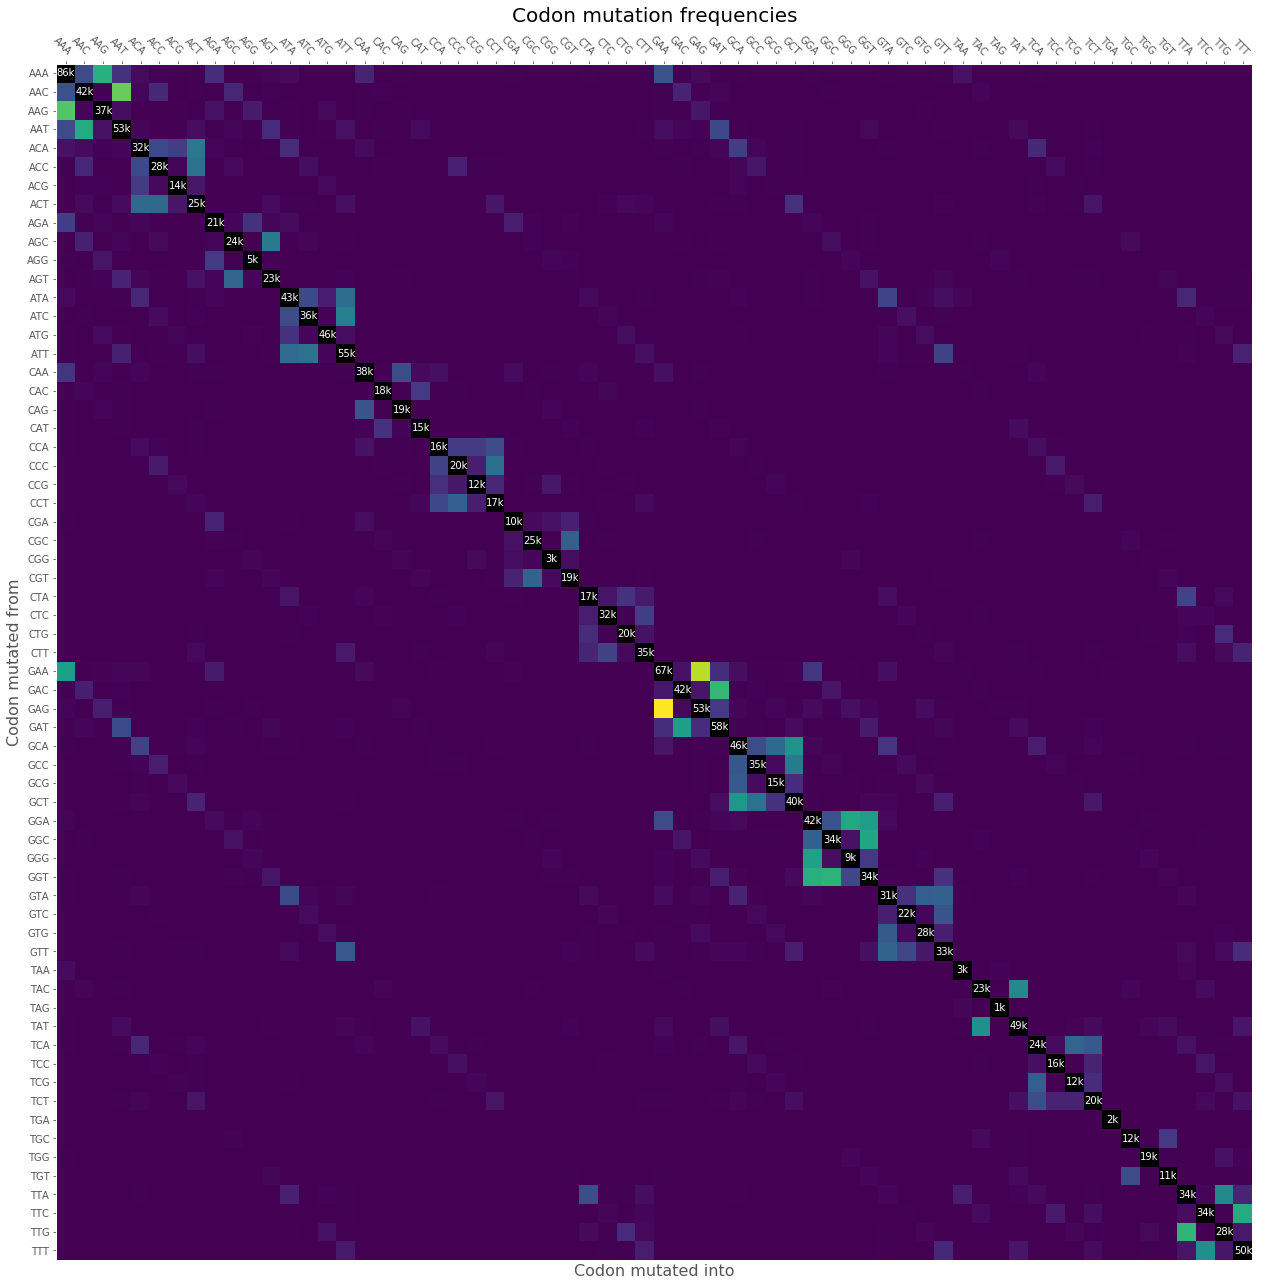

In [112]:
viz_mutmatrix(sorted(codon2freq.keys()), codon2freq, codon2codon2freq, "viridis", "Codon")

Most common codon mutations:
1. GAG --> GAA: frequency 423
2. GAA --> GAG: frequency 379
3. AAC --> AAT: frequency 325
4. AAG --> AAA: frequency 309
5. GAC --> GAT: frequency 282
6. TTG --> TTA: frequency 277
7. GGT --> GGC: frequency 274
8. AAA --> AAG: frequency 269
9. GGT --> GGA: frequency 266
10. TTC --> TTT: frequency 260


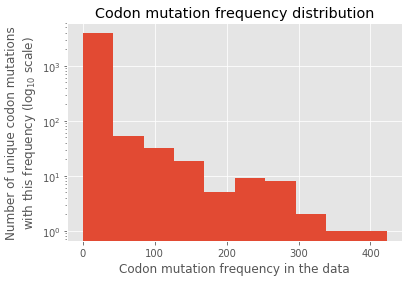

In [113]:
plot_freq_distribution(codon2codon2freq, "Codon")

### Amino acid (+ stop codon) matrix

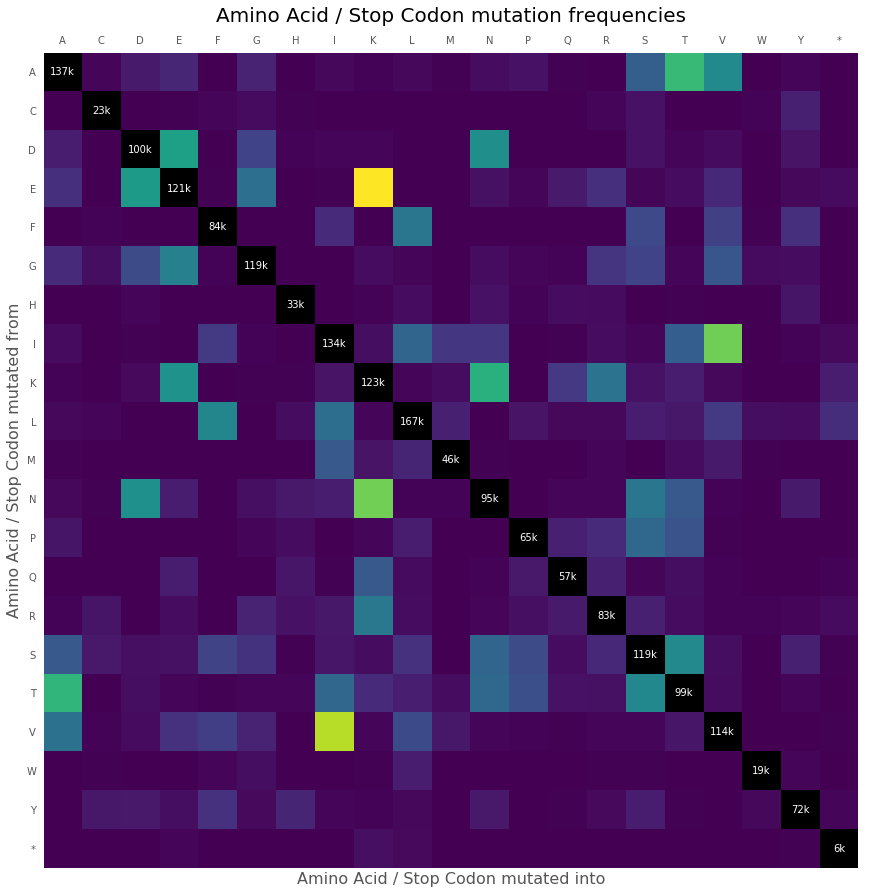

In [114]:
# Sorting will, by default, put the "*" (the stop codon) at the start of the list. To avoid this,
# we manually remove it from the list and then move it to the end (which IMO makes the most sense as
# a location for it relative to the actual amino acids).
aas = sorted(aa2freq.keys())
aas.remove("*")
aas += ["*"]
viz_mutmatrix(
    aas, aa2freq, aa2aa2freq, "viridis", "Amino Acid / Stop Codon",
    w=15, h=15,
    rotate_xlabels=False,
    show_ticks=False
)

Most common amino acid / stop codon mutations:
1. E --> K: frequency 286
2. V --> I: frequency 255
3. N --> K: frequency 225
4. I --> V: frequency 224
5. A --> T: frequency 193
6. T --> A: frequency 188
7. K --> N: frequency 182
8. D --> E: frequency 162
9. E --> D: frequency 156
10. K --> E: frequency 146


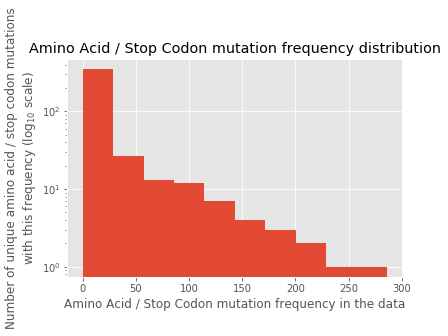

In [115]:
plot_freq_distribution(aa2aa2freq, "Amino Acid / Stop Codon")